In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
df = pd.read_csv('smart_traffic_management_dataset.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')

label_encoders = {}
for col in ['weather_condition', 'signal_status']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

features = df.drop(columns=['timestamp', 'traffic_volume'])
target = df['traffic_volume'].values.reshape(-1, 1)

scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(features)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(target)

In [3]:
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len, :-1])
        y.append(data[i+seq_len, -1])
    return np.array(X), np.array(y)

In [4]:
data_combined = np.hstack((X_scaled, y_scaled))
SEQ_LEN = 10
X_seq, y_seq = create_sequences(data_combined, SEQ_LEN)

In [5]:
X_cnnlstm = X_seq.reshape((X_seq.shape[0], SEQ_LEN, X_seq.shape[2], 1))
X_train, X_test, y_train, y_test = train_test_split(X_cnnlstm, y_seq, test_size=0.2, random_state=42)

In [6]:
model_cnnlstm = Sequential([
    TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='relu'), input_shape=(SEQ_LEN, X_seq.shape[2], 1)),
    TimeDistributed(MaxPooling1D(pool_size=2)),
    TimeDistributed(Flatten()),
    Dropout(0.3),
    LSTM(100, activation='tanh', return_sequences=True),
    LSTM(50, activation='tanh'),
    Dropout(0.2),
    Dense(1, activation='relu')
])
model_cnnlstm.compile(optimizer='adam', loss='mse', metrics=['mae'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)
]

history = model_cnnlstm.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50


C:\Users\aidilfadzni\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1144 - mae: 0.2853 - val_loss: 0.0761 - val_mae: 0.2305 - learning_rate: 0.0010
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0896 - mae: 0.2580 - val_loss: 0.0749 - val_mae: 0.2318 - learning_rate: 0.0010
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0904 - mae: 0.2592 - val_loss: 0.0777 - val_mae: 0.2369 - learning_rate: 0.0010
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0904 - mae: 0.2607 - val_loss: 0.0746 - val_mae: 0.2306 - learning_rate: 0.0010
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0873 - mae: 0.2533 - val_loss: 0.0762 - val_mae: 0.2300 - learning_rate: 0.0010
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0862 - mae: 0.2519 - val_loss: 0.0758 - val_mae: 0.2337 - learning_rate: 0.0010
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0875 - mae: 0.2566 - val_loss: 0.0771 - val_mae: 0.2358 - learning_rate: 0.0010
Epoch 8/50
100/1

In [7]:
y_pred = model_cnnlstm.predict(X_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


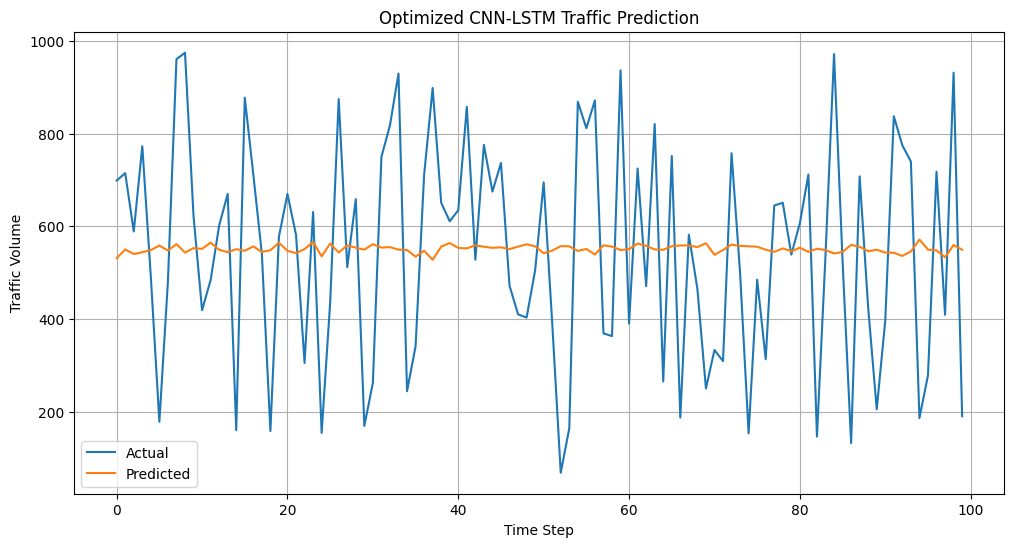

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv[:100], label='Actual')
plt.plot(y_pred_inv[:100], label='Predicted')
plt.title("Optimized CNN-LSTM Traffic Prediction")
plt.xlabel("Time Step")
plt.ylabel("Traffic Volume")
plt.legend()
plt.grid(True)
plt.show()